In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/all-aspects/all_aspects_just_aspect.csv
/kaggle/input/all-aspects/all_tagged_aspects_just_aspect_cleaned.csv
/kaggle/input/all-aspects/all_tagged_aspects_just_aspect_filled.csv
/kaggle/input/all-aspects/all_tagged_aspects_filled.csv
/kaggle/input/all-aspects/all_tagged_aspects_just_aspect.csv
/kaggle/input/all-aspects/all_tagged_aspects_sentences.csv
/kaggle/input/all-aspects/all_tagged_aspects_just_aspect_sentences.csv
/kaggle/input/all-aspects/all_aspects_just_aspect_cleaned.csv
/kaggle/input/all-aspects/all_tagged_aspects_just_aspect_filled_sentences.csv
/kaggle/input/all-aspects/reviews.csv
/kaggle/input/all-aspects/cleaned.csv
/kaggle/input/all-aspects/all_aspects_just_aspect_filled.csv
/kaggle/input/all-aspects/all_tagged_aspects.csv
/kaggle/input/all-aspects/all_aspects.csv
/kaggle/input/all-aspects/all_tagged_aspects_just_aspect_cleaned_sentences.csv


In [4]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import sys
import time
import tqdm

import numpy as np
import pandas as pd

import pickle

import string
import io
import re
import nltk
import emoji

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_confusion_matrix

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

from IPython.display import Markdown, clear_output

def bold(string):
    display(Markdown("**" + string + "**"))

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
df = pd.read_csv("../input/all-aspects/cleaned.csv")

In [7]:
df.isnull().sum()

rid                  0
sid                  0
app                  0
review               0
sentiment            0
aspect               0
aspect_polarity      0
cleaned            368
text                 0
dtype: int64

In [8]:
df = df.dropna().reset_index(drop=True)

In [9]:
label_mapping = {"Negative": 0, "Neutral": 1, "Positive": 2}

In [10]:
df['text'] = df['aspect'] + " [SEP] " + df['review']

In [11]:
df = df[["text", "aspect_polarity"]]

In [12]:
tokenizer = BertTokenizerFast.from_pretrained("dbmdz/bert-base-turkish-128k-cased")
model = BertForSequenceClassification.from_pretrained("dbmdz/bert-base-turkish-128k-cased", num_labels=3).to(device)

tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/386 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-128k-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [14]:
def train_validate_test_split(df, split_size):
    perm = np.random.permutation(df.index)
    train_end = int(train_size * len(df.index))
    validate_end = int(((1 - split_size) / 2) * len(df.index)) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [15]:
train_size = 0.9
df_train, df_validation, df_test = train_validate_test_split(df, train_size)
df_train = df_train.reset_index(drop=True)
df_validation = df_validation.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(f"Full dataset: {df.shape[0]}")
print(f"Train dataset: {df_train.shape[0]}")
print(f"Valid dataset: {df_validation.shape[0]}")
print(f"Test dataset: {df_test.shape[0]}")

Full dataset: 162148
Train dataset: 145933
Valid dataset: 8107
Test dataset: 8108


In [16]:
MAX_LEN = 64
BATCH_SIZE = 64
EPOCHS = 4
LEARNING_RATE = 2e-5

In [17]:
training_set = SentimentDataset(df_train["text"].to_numpy(), df_train["aspect_polarity"].to_numpy(), tokenizer, MAX_LEN)
validation_set = SentimentDataset(df_validation["text"].to_numpy(), df_validation["aspect_polarity"].to_numpy(), tokenizer, MAX_LEN)
testing_set = SentimentDataset(df_test["text"].to_numpy(), df_test["aspect_polarity"].to_numpy(), tokenizer, MAX_LEN)

In [18]:
train_params = {"batch_size": BATCH_SIZE, "shuffle": True, "num_workers": 0}
valid_params = {"batch_size": BATCH_SIZE, "shuffle": True, "num_workers": 0}
test_params = {"batch_size": BATCH_SIZE, "shuffle": True, "num_workers": 0}

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **valid_params)
testing_loader = DataLoader(testing_set, **test_params)

In [19]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
total_steps = len(training_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [20]:
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in tqdm.tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

In [21]:
def eval_model(model, data_loader, device):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in tqdm.tqdm(data_loader):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

In [22]:
%%time

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(model, training_loader, optimizer, scheduler, device)
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(model, validation_loader, device)
    print(f'Val   loss {val_loss} accuracy {val_acc}')

Epoch 1/4
----------


100%|██████████| 2281/2281 [23:10<00:00,  1.64it/s]


Train loss 0.4832320123100845 accuracy 0.8190059821973097


100%|██████████| 127/127 [00:26<00:00,  4.81it/s]


Val   loss 0.41851177307095117 accuracy 0.849759467127174
Epoch 2/4
----------


100%|██████████| 2281/2281 [23:13<00:00,  1.64it/s]


Train loss 0.37160096711453405 accuracy 0.8666991016425346


100%|██████████| 127/127 [00:26<00:00,  4.81it/s]


Val   loss 0.3713859921599936 accuracy 0.8683853459972862
Epoch 3/4
----------


100%|██████████| 2281/2281 [23:13<00:00,  1.64it/s]


Train loss 0.2891528352258865 accuracy 0.8980491047261414


100%|██████████| 127/127 [00:26<00:00,  4.80it/s]


Val   loss 0.3500370687152457 accuracy 0.8775132601455532
Epoch 4/4
----------


100%|██████████| 2281/2281 [23:12<00:00,  1.64it/s]


Train loss 0.23271445372925417 accuracy 0.918791500209


100%|██████████| 127/127 [00:26<00:00,  4.81it/s]

Val   loss 0.34379579056435683 accuracy 0.884297520661157
CPU times: user 1h 34min 36s, sys: 7.05 s, total: 1h 34min 43s
Wall time: 1h 34min 36s


In [23]:
y_pred = []
y_true = []

model = model.eval()

with torch.no_grad():
    for d in testing_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)

        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

In [24]:
model_precision_score = precision_score(y_true, y_pred, average='macro')
model_f1_score = f1_score(y_true, y_pred, average='macro')
model_recall_score = recall_score(y_true, y_pred, average='macro')
model_accuracy_score = accuracy_score(y_true, y_pred)

print(f"Precision Score = {model_precision_score * 100:.2f}%")
print(f"F1 Score = {model_f1_score * 100:.2f}%")
print(f"Recall Score = {model_recall_score * 100:.2f}%")
print(f"Accuracy Score = {model_accuracy_score * 100:.2f}%")

Precision Score = 80.46%
F1 Score = 76.39%
Recall Score = 73.93%
Accuracy Score = 88.89%


In [25]:
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.89      0.95      0.92      4495
     Neutral       0.61      0.40      0.48       424
    Positive       0.91      0.87      0.89      3189

    accuracy                           0.89      8108
   macro avg       0.80      0.74      0.76      8108
weighted avg       0.88      0.89      0.88      8108



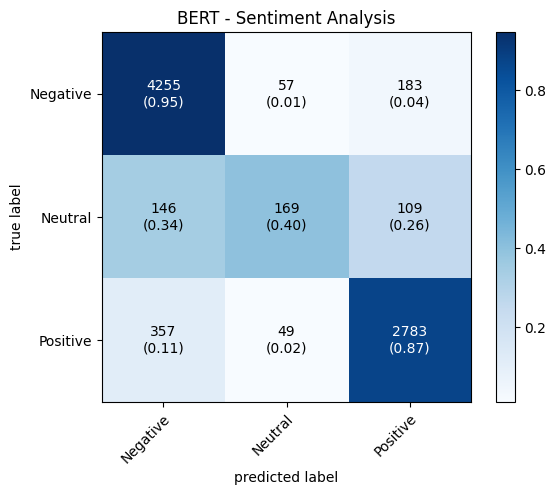

In [26]:
cm = confusion_matrix(y_true, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["Negative", "Neutral", "Positive"])
plt.title("BERT - Sentiment Analysis")
plt.show()